Project Name : Advanced Time Series Forecasting using LSTM with Attention



1. Importing Libraries

First, we import all the required Python libraries for data processing, visualization, machine learning, and deep learning.

In [1]:
# 1. Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Attention
from tensorflow.keras.models import Model


2. Synthetic Dataset Generation

A synthetic multivariate time series dataset is generated programmatically using NumPy.

In [2]:
#2. Synthetic Dataset Generation

np.random.seed(42)
tf.random.set_seed(42)
n = 1500
t = np.arange(n)

trend = 0.01 * t
seasonal = 2 * np.sin(2 * np.pi * t / 50)

f1 = trend + seasonal + np.random.normal(0, 0.5, n)
f2 = 0.5 * f1 + np.random.normal(0, 0.3, n)
f3 = np.cos(t / 20) + np.random.normal(0, 0.2, n)
f4 = np.sin(t / 15) + np.random.normal(0, 0.2, n)
f5 = trend + np.random.normal(0, 0.4, n)

target = 0.3 * f1 + 0.2 * f2 + 0.4 * f3 + seasonal + np.random.normal(0, 0.3, n)

data = pd.DataFrame({
                      'f1' : f1,
                      'f2' : f2,
                      'f3' : f3,
                      'f4' : f4,
                      'f5' : f5,
                      'y' : target
                    })
data.head()

,f1,f2,f3,f4,f5,y
0,0.248357,0.357687,0.618438,-0.191756,-0.445633,0.911128
1,0.191534,-0.069589,0.826673,-0.203884,-0.242372,0.661432
2,0.841224,0.175152,0.912283,-0.183779,-0.356824,1.375716
3,1.527764,0.762870,1.366309,0.281269,-0.189198,1.923624
4,0.886431,0.392160,1.091377,0.220704,-0.045660,1.544219


3. Data Visualization

The target time series is plotted using Matplotlib

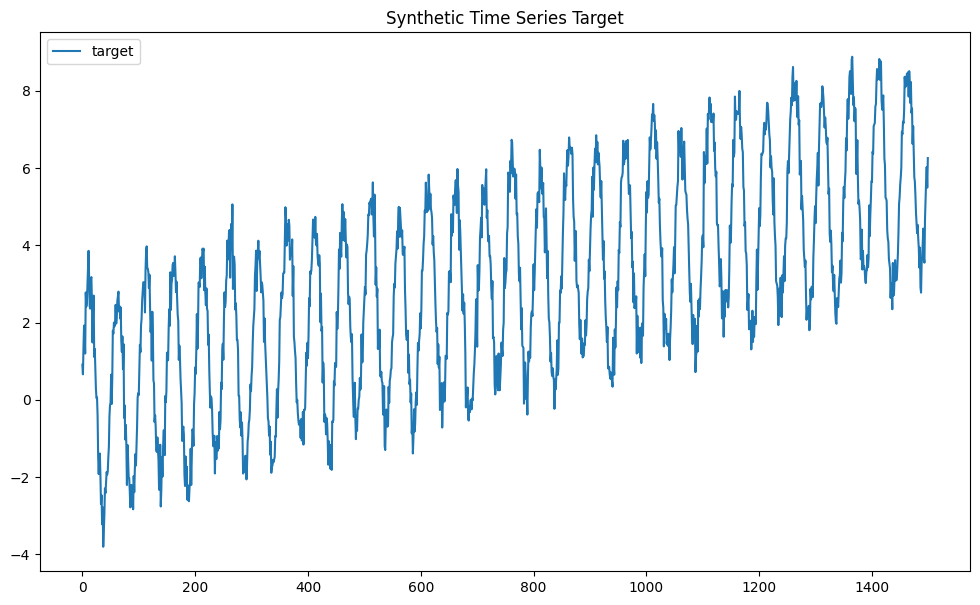

In [3]:
# 3 dagta visualization

plt.figure(figsize = (12, 7))
plt.plot(data['y'], label = 'target')
plt.title("Synthetic Time Series Target")
plt.legend()
plt.show()

Data Scaling

The entire dataset is standardized using StandardScaler.

Sequence Creation (Supervised Learning)

A sliding window approach is used to convert the time series into supervised learning format

Train-Test Split

This split preserves the temporal order of the data, which is essential in time series problems

In [4]:
# 4 Scaling and Sequence Creation and Train Test Split

def create_sequences(data, seq_len = 30):
  x, y = [], []
  for i in range(len(data) - seq_len):
    x.append(data[i : i + seq_len, : -1])
    y.append(data[i + seq_len, -1])
  return np.array(x), np.array(y)

SEQ_LEN = 30

split_raw = int(0.8 * len(data))
train_raw = data[:split_raw]
test_raw = data[split_raw:]

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_raw)
test_scaled = scaler.transform(test_raw)

# Create sequences from the scaled data
x_train, y_train = create_sequences(train_scaled, SEQ_LEN)
x_test, y_test = create_sequences(test_scaled, SEQ_LEN)

 LSTM with Attention Model

 A deep learning model is constructed using Keras

In [5]:
# 5 LSTM and attention model

inputs = Input(shape = (SEQ_LEN, 5))
lstm_out = LSTM(64, return_sequences = True)(inputs)

attn = Attention(name = "attention_layer")([lstm_out, lstm_out])
context = tf.keras.ops.mean(attn, axis = 1)

output = Dense(1)(context)

model = Model(inputs , output)
model.compile(optimizer = "adam", loss = "mse")
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 30, 64)    │     17,920 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 30, 64)    │          0 │ lstm[0][0],       │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Mean)         │ (None, 64)        │          0 │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         65 │ mean[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,985 (70.25 KB)

 Trainable params: 17,985 (70.25 KB)

 Non-trainable params: 0 (0.00 B)

Rolling Time Series Cross-Validation

Rolling cross-validation is performed using TimeSeriesSplit

In [6]:
# 6 rolling cross validation

tscv = TimeSeriesSplit(n_splits = 5)

for fold, (train_idx, val_idx) in enumerate(tscv.split(x_train)):
  print(f"Fold {fold + 1}")
  x_tr, x_val = x_train[train_idx], x_train[val_idx]
  y_tr, y_val = y_train[train_idx], y_train[val_idx]

  model.fit(x_tr, y_tr,
            validation_data = (x_val, y_val),
            epochs = 10,
            batch_size = 32,
            verbose = 0)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


Final Model Training

After cross-validation, the model is trained on the full training dataset

In [7]:
# 7 final training

history = model.fit(x_train, y_train,
                    epochs = 20,
                    batch_size = 32,
                    verbose = 0,
                    validation_split = 0.01)

Deep Learning Model Evaluation

Predictions are generated on the test set

In [8]:
# 8 deeplearning evalution

y_pred_d1 = model.predict(x_test)

rmse_d1 = np.sqrt(mean_squared_error(y_test, y_pred_d1))
mae_d1 = mean_absolute_error(y_test, y_pred_d1)
mape_d1 = np.mean(np.abs((y_test - y_pred_d1.flatten()) / y_test)) * 100

print("LSTM + Attention:\n")
print("RMSE:L\n", rmse_d1)
print("MAE:\n", mae_d1)
print("MAPE:\n", mape_d1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
LSTM + Attention:

RMSE:L
 0.2968167164784146
MAE:
 0.2399217561321221
MAPE:
 74.87245721847884


Baseline Model (SARIMA)

A classical SARIMA model is trained on the same target time series

In [9]:
# 9 base line SARIMA modelt

from statsmodels.tsa.statespace.sarimax import SARIMAX

train_series = data['y'][:split_raw + SEQ_LEN]
test_series = data['y'][split_raw + SEQ_LEN:]

sarima = SARIMAX(train_series, order = (3, 1, 3))
sarima_fit = sarima.fit()

sarima_pred = sarima_fit.forecast(len(test_series))

rmse_s = np.sqrt(mean_squared_error(test_series, sarima_pred))
mae_s = mean_absolute_error(test_series, sarima_pred)
mape_s = np.mean(np.abs((test_series - sarima_pred) / test_series)) * 100

print("SARIMA:\n")
print("RMSE:\n", rmse_s)
print("MAE:\n", mae_s)
print("MAPE:\n", mape_s)

SARIMA:

RMSE:
 0.769281694242092
MAE:
 0.6174820618639003
MAPE:
 12.929838683932365


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Results Comparison

A comparison table is created using Pandas

In [10]:
# 10 result comparison table

results = pd.DataFrame({
    "Mode1" : ["SARIMA", "LSTM + Attention"],
    "RMSE" : [rmse_s, rmse_d1],
    "MAE" : [mae_s, mae_d1],
    "MAPE" : [mape_s, mape_d1]
})

results

,Mode1,RMSE,MAE,MAPE
0,SARIMA,0.769282,0.617482,12.929839
1,LSTM + Attention,0.296817,0.239922,74.872457


Attention Weights Extraction

A separate model is created to extract the output of the attention layer

In [11]:
# 11 attention weights extraction

attn_model = Model(inputs = model.input,
                   outputs = model.get_layer("attention_layer").output
                   )
weights = attn_model.predict(x_test[:1])
print(weights.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
(1, 30, 64)


Attention Visualization

The attention weights are visualized using a heatmap

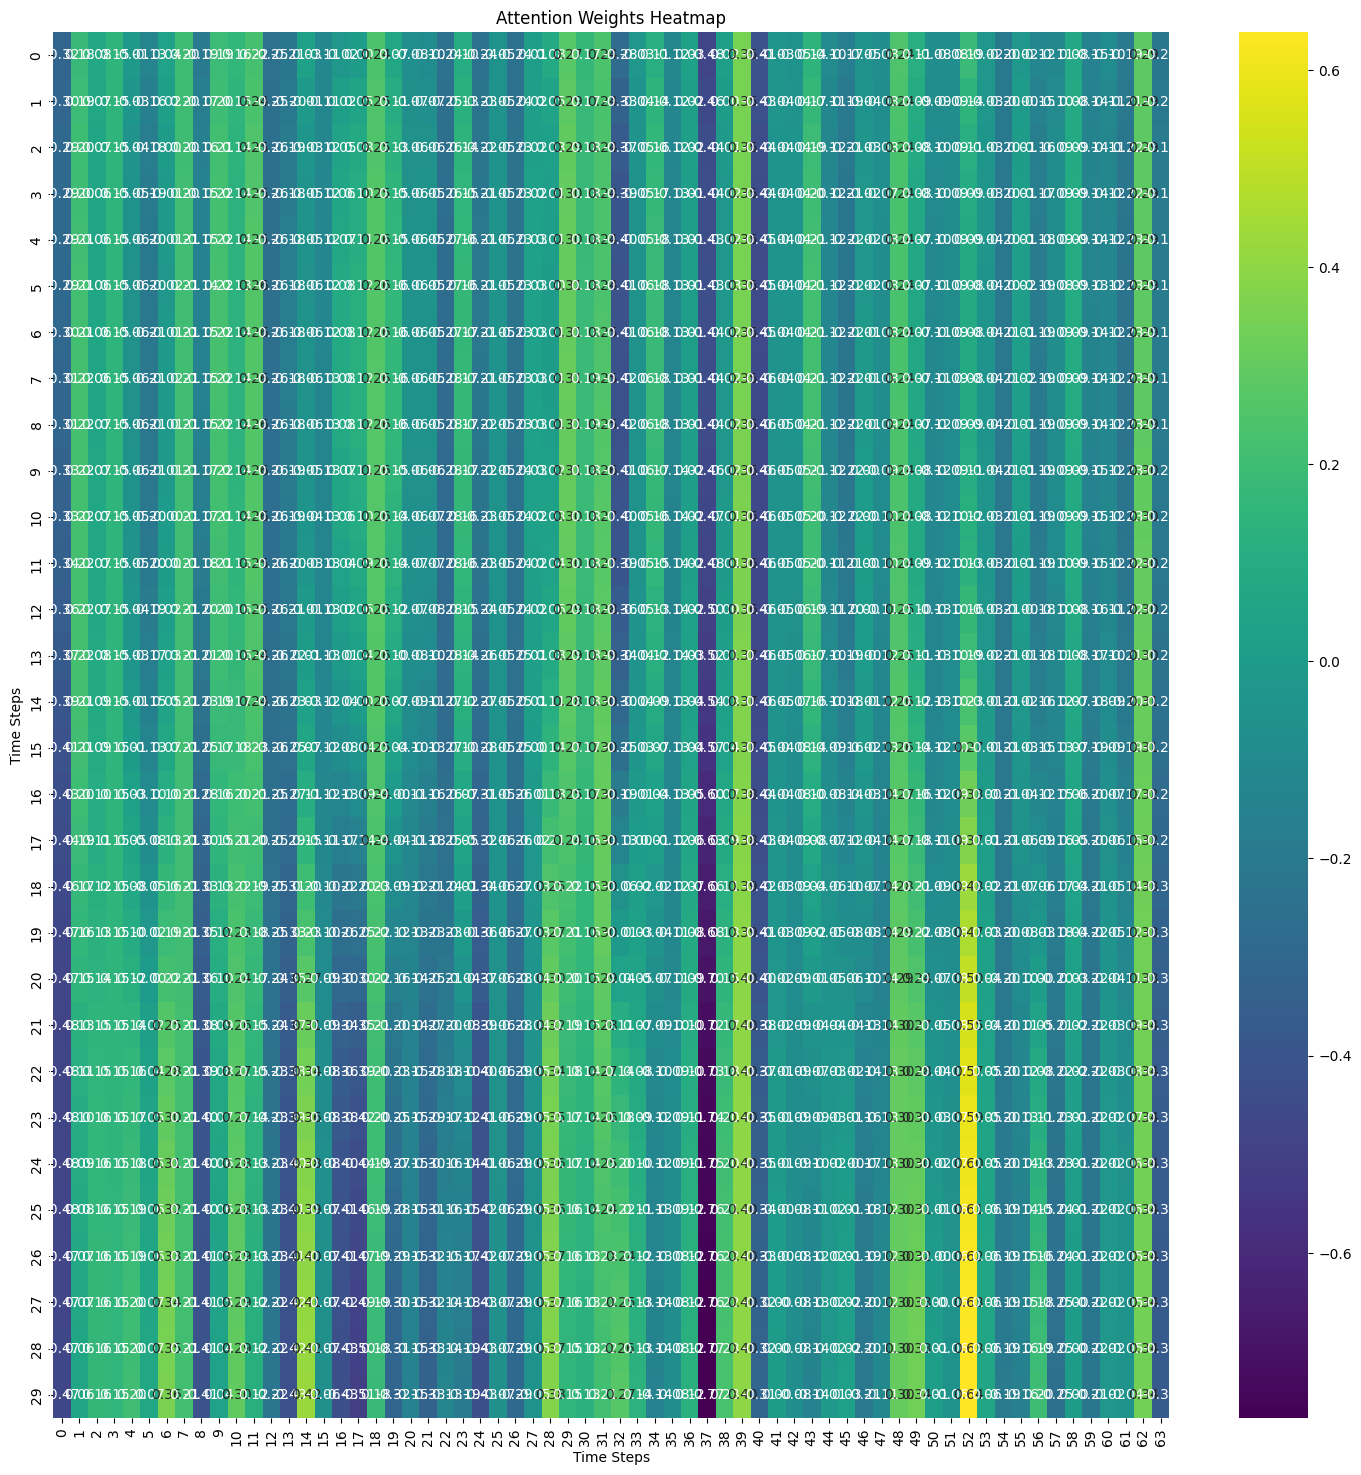

In [12]:
# 12 attention visualization

plt.figure(figsize = (18,18))
sns.heatmap(weights[0], cmap = "viridis", annot = True, fmt = ".2f")
plt.title("Attention Weights Heatmap")
plt.xlabel("Time Steps")
plt.ylabel("Time Steps")
plt.show()

Final Prediction Plot

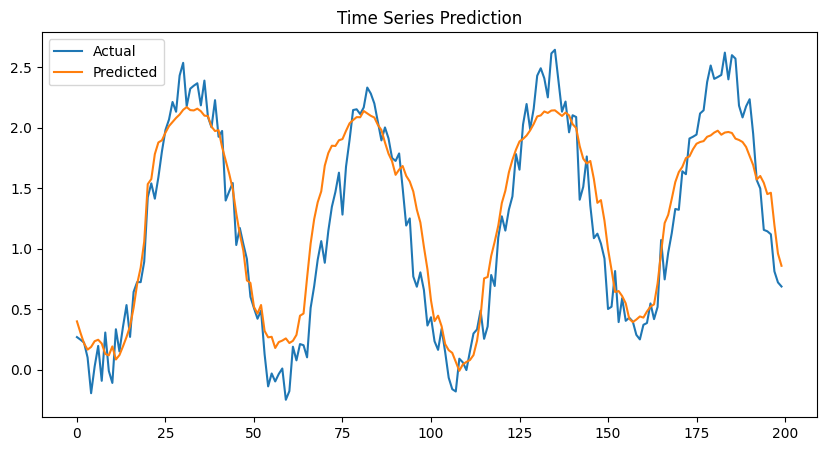

In [13]:
# 13 final plot

plt.figure(figsize = (10, 5))
plt.plot(y_test[:200], label = "Actual")
plt.plot(y_pred_d1[:200], label = "Predicted")
plt.title("Time Series Prediction")
plt.legend()
plt.show()